In [1]:
# I like to start by checking if the GPU was initiated succesfully,
# and by seeing the tensroflow and python versions being used
# by the notebook.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
import os, sys, tarfile, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)


[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12769015033601147952
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11324823962
locality {
  bus_id: 1
}
incarnation: 18163191582676383813
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python


Reading .npy and .pkl files....
Runtime: 0 min 7 sec


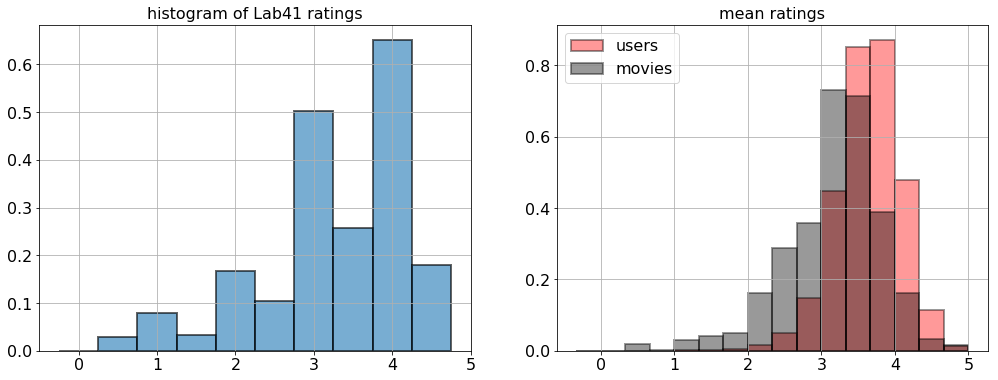

In [2]:
# Read Lab41 dataset into: train_Y, cv_Y, test_Y
#                          train_Y_indices, cv_Y_indices, test_Y_indices

start = time.time()
#...................................................
train_Y_indices, train_Y, cv_Y_indices, \
        cv_Y, test_Y_indices, test_Y, \
        n_users, n_movies, u_mean_dict, v_mean_dict = read_and_split_data()

#...................................................

ax = plt.subplot(121)
ax.hist(np.concatenate((train_Y, cv_Y, test_Y)), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
         edgecolor='black', linewidth=2, normed=True);
ax.set_title('histogram of Lab41 ratings');

#...................................................

ax = plt.subplot(122)
ax.hist((list(u_mean_dict.values())), bins=np.arange(-1/3, 5+1/3, 1/3), alpha=.4, \
        color='red', edgecolor='black', linewidth=2, normed=True);
ax.set_title('mean ratings');

ax.hist((list(v_mean_dict.values())), bins=np.arange(-1/3, 5+1/3, 1/3), alpha=.4, \
        color='black', edgecolor='black', linewidth=2, normed=True);

ax.legend(('users','movies'))

print_runtime(start)

In [3]:
def get_train_u_mean(train_Y_indices, u_mean_dict, v_mean_dict):
    N = train_Y_indices.shape[0]
    train_u_mean = np.zeros((N, 1))
    train_v_mean = np.zeros((N, 1))
    for i in range(N):
        u_idx = train_Y_indices[i,0]
        v_idx = train_Y_indices[i,1]
        train_u_mean[i] = u_mean_dict[u_idx]
        train_v_mean[i] = v_mean_dict[v_idx]

    return train_u_mean, train_v_mean

start = time.time()
train_u_mean, train_v_mean = get_train_u_mean(train_Y_indices, u_mean_dict, v_mean_dict)

print_runtime(start)

Runtime: 0 min 16 sec


In [10]:
train_u_mean.shape, n_users, n_movies, BATCH_SIZE


((12800168, 1), 138493, 26744, 16384)

In [11]:
UV_xft.get_shape()

TensorShape([Dimension(10), Dimension(10)])

In [18]:
start = time.time()    

# hyperparameters
# BATCH_SIZE = 1024*16
BATCH_SIZE_arr = [1024*16]
# LAMBDA_ARR = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.00125]
LAMBDA = 0.001
k = 10 # an important hyperparameter.
lr = 0.01
NUM_EPOCHS = 10
if 'out.txt' in os.listdir(): 
    os.remove('out.txt')

for BATCH_SIZE in BATCH_SIZE_arr:
    #.............................................. 
    train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft, u_mean, v_mean = \
                            construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
    #.............................................. 
    
    mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds, \
                   _U, _V, _UV_xft, _UU_xft, _VV_xft = \
        train_the_model(Y_indices, Y, train_Y_indices, train_Y, BATCH_SIZE, 
                   NUM_EPOCHS, LAMBDA, k, lr, 
                   train, loss, reg, U, V, Y_pred,
                   cv_Y, cv_Y_indices, test_Y, test_Y_indices,
                   UV_xft, UU_xft, VV_xft, 
                   train_u_mean, train_v_mean, u_mean, v_mean)
    #.............................................. 
    # plotting....
    ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)

#.............................................. 
print_runtime(start)

xft.get_shape(): (16384,)
lin.get_shape(): (16384,) 
xft.get_shape(): (16384,)
Y_pred.get_shape(): (16384,) 
loss.get_shape(): () 
tf.sqrt(tf.reduce_sum((Y - Y_pred)**2)/BATCH_SIZE): <tf.Tensor 'Sqrt_27:0' shape=() dtype=float32>
reg.get_shape(): () 
UV_xft.get_shape(): (10, 10) 
UU_xft.get_shape(): (10, 10) 
VV_xft.get_shape(): (10, 10) 
stacked_U.get_shape(): (16384, 10) 
stacked_V.get_shape(): (16384, 10) 
tf.reduce_sum(tf.multiply(stacked_U, stacked_V), axis=1).get_shape(): (16384,) 

NUM_EPOCHS: 10
LAMBDA: 0.001
k: 10
lr: 0.01
n_batches: 781
BATCH_SIZE: 16384
New epoch: 1 ******************************


InvalidArgumentError: Invalid indices: [4667,0,0] = [26970, 0] does not index into [26744,10]
	 [[Node: gradients_13/GatherNd_53_grad/ScatterNd = ScatterNd[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](stack_53/_19, gradients_13/Mul_2769_grad/tuple/control_dependency_1/_21, gradients_13/GatherNd_53_grad/Shape)]]
	 [[Node: gradients_13/GatherNd_52_grad/ScatterNd/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_234_gradients_13/GatherNd_52_grad/ScatterNd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'gradients_13/GatherNd_53_grad/ScatterNd', defined at:
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-c061e856f988>", line 16, in <module>
    train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft, u_mean, v_mean =                             construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
  File "/home/aind2/miscelleneous_projects/fellowship.ai/ml-20m/helpers.py", line 410, in construct_graph
    train = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 288, in minimize
    grad_loss=grad_loss)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 354, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/ops/array_grad.py", line 368, in _GatherNdGrad
    ref_grad = array_ops.scatter_nd(indices, grad, ref_shape)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2942, in scatter_nd
    shape=shape, name=name)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'GatherNd_53', defined at:
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-18-c061e856f988>", line 16, in <module>
    train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft, u_mean, v_mean =                             construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
  File "/home/aind2/miscelleneous_projects/fellowship.ai/ml-20m/helpers.py", line 364, in construct_graph
    stacked_U, stacked_V, stacked_u_mean, stacked_v_mean = get_stacked_UV(Y_indices, Y, U, V, k, u_mean, v_mean, BATCH_SIZE)
  File "/home/aind2/miscelleneous_projects/fellowship.ai/ml-20m/helpers.py", line 186, in get_stacked_UV
    stacked_V = tf.gather_nd(V, indices_V)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1473, in gather_nd
    name=name)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/aind2/anaconda3/envs/aind-dog/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Invalid indices: [4667,0,0] = [26970, 0] does not index into [26744,10]
	 [[Node: gradients_13/GatherNd_53_grad/ScatterNd = ScatterNd[T=DT_FLOAT, Tindices=DT_INT32, _device="/job:localhost/replica:0/task:0/cpu:0"](stack_53/_19, gradients_13/Mul_2769_grad/tuple/control_dependency_1/_21, gradients_13/GatherNd_53_grad/Shape)]]
	 [[Node: gradients_13/GatherNd_52_grad/ScatterNd/_29 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_234_gradients_13/GatherNd_52_grad/ScatterNd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [15]:
# # hyperparameters
# # BATCH_SIZE = 1024*16
# BATCH_SIZE_arr = [1024*128, 1024*64, 1024*32, 1024*16]
# # LAMBDA_ARR = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.00125]
# LAMBDA = 0
# k = 10 # an important hyperparameter.
# lr = 0.01
# NUM_EPOCHS = 30
# if 'out.txt' in os.listdir(): 
#     os.remove('out.txt')
    
# for BATCH_SIZE in BATCH_SIZE_arr:
#     #.............................................. 
#     train, loss, reg, Y_indices, Y, U, V, Y_pred, UV_xft, UU_xft, VV_xft = \
#                             construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
#     #.............................................. 

#     start = time.time()
#     mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds, \
#                    _U, _V, _UV_xft, _UU_xft, _VV_xft = \
#                          train_the_model(Y_indices, Y, train_Y_indices, train_Y, BATCH_SIZE, 
#                    NUM_EPOCHS, LAMBDA, k, lr, 
#                    train, loss, reg, U, V, Y_pred,
#                    cv_Y, cv_Y_indices, test_Y, test_Y_indices,
#                    UV_xft, UU_xft, VV_xft)
#     #.............................................. 
#     # plotting....
#     ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)

# #.............................................. 
# print_runtime(start)

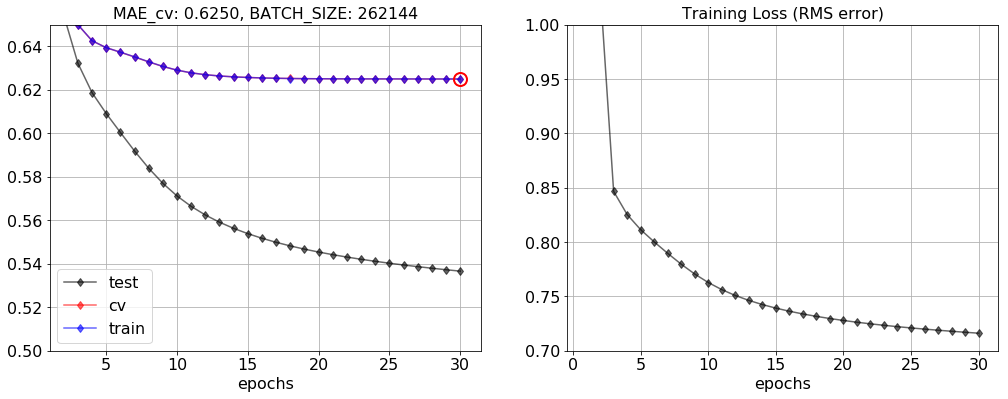

In [7]:
ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)